# ADVERSARIAL IMAGES

In [ ]:
# ==========================================================¶
# Date : 11 dec. 2018
# MS Valdom > apprenants > omar attaf, laurent lapasset, didier le picaut
# version = 1.0
# ==========================================================

In [2]:
#================
# objectif : 
#================
# tester l'ajout de perturbations imperceptibles à une image peut entraîner 
# des performances de modèle radicalement différentes

In [3]:
# attaquer les réseaux de neurones en exploitant la façon dont ils apprennent,
# les gradients. L'idée est simple, plutôt que de chercher à minimiser la perte 
# en ajustant les poids en fonction des gradients rétropropagés, 
# l'attaque ajuste les données d'entrée pour maximiser la perte en fonction 
# des mêmes gradients rétrogradés. En d'autres termes, l'attaque utilise le gradient
# de la perte par rapport aux données d'entrée, 
# puis ajuste les données d'entrée pour maximiser la perte.

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Debut du decompte du temps
import time
start_time = time.time()

In [6]:
SEED = 1

# cuda est tu la ?
cuda = torch.cuda.is_available()

# reproductibilite
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [7]:
# les parametres
#================
# epsilons - 
#================
# Liste des valeurs epsilon à utiliser pour l'exécution. 
# Il est important de conserver 0 dans la liste, car il représente 
# les performances du modèle sur l'ensemble de test d'origine. 
# En outre, intuitivement, nous nous attendrions à ce que plus epsilon soit grand, 
# plus les perturbations soient perceptibles, 
# mais plus l'attaque est efficace en termes de dégradation de la précision du modèle.
# Puisque la plage de données est ici [0,1], aucune valeur epsilon ne doit dépasser 1.

#================
#pretrained_model -
#================
# modèle MNIST pré-entrainé qui a été formé avec pytorch

In [8]:
#================
# la pertubation liste a la main = epsilons
#================

#epsilons = [0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1]
epsilons = [0, .05, .1, .15, .2, .25, .3]

pretrained_model = "data/lenet_mnist_model.pth"
# https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h

use_cuda=True

In [9]:
# le modele : LeNet Model definition == Cnn 2 convolutions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test du jeu de données et déclaration du dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Définir quel appareil nous utilisons
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialiser le réseau
model = Net().to(device)

# Charger le modèle pré-entrainé
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Définissez le modèle en mode d'évaluation.cf dropout
model.eval()


CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
#================
# FGSM Attack : 
#================

# L’une des premières et des plus populaires attaques contradictoires
# à ce jour est l’ attaque du signe à gradient rapide (FGSM) et est décrite 
# par Goodfellow et. Al. dans l' explication et l'exploitation
# des exemples contradictoires . 

# définir la fonction qui crée les exemples contradictoires en perturbant les entrées 
# d'origine. La fgsm_attack fonction prend trois entrées, image est l’image vierge 
# originale (x), epsilon est la quantité de perturbation exprimée en pixels (ϵ), 
# et data_grad est un gradient de la perte par rapport à l'image d'entrée (∇xJ(θ,x,y)). 
# La fonction crée alors une image perturbée comme 
# perturbed_image = image+epsilon∗sign(data_grad) = x+ϵ∗sign(∇xJ(θ,x,y))
# 
# Enfin, afin de conserver la plage initiale des données, 
# l’image perturbée est découpée en plage. [0,1].

In [11]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    
    # Collecte le signe élémentaire du dégradé de données
    sign_data_grad = data_grad.sign()
    
    # Créez l'image perturbée en ajustant chaque pixel de l'image d'entrée
    perturbed_image = image + epsilon*sign_data_grad
    
    # Ajout de découpage pour maintenir la plage [0,1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Renvoyer l'image perturbée
    return perturbed_image

In [12]:
#================
# Fonction de test : 
#================
# Chaque appel à cette fonction de test exécute une étape de test complète 
# sur le jeu de tests MNIST et rapporte une précision finale. 
# Cependant, notez que cette fonction prend également une entrée epsilon .
# En effet, la test fonction signale la précision d’un modèle attaqué par un adversaire
# puissant.ϵ. Plus spécifiquement, pour chaque échantillon de l’ensemble de test,
# la fonction calcule le gradient de la perte par rapport aux données d’entrée (data_grad),
# crée une image perturbée avec fgsm_attack(perturbed_data), 
# puis vérifie si l’exemple perturbé est contradictoire. 
# En plus de tester la précision du modèle, la fonction enregistre et renvoie 
# certains exemples de confrontation réussis à visualiser ultérieurement.

In [13]:
def test( model, device, test_loader, epsilon ):

    # Compteur de précision
    correct = 0
    adv_examples = []

    # Boucle sur tous les exemples de l'ensemble de test
    for data, target in test_loader:

        # Envoyer les données et l'étiquette à l'appareil
        data, target = data.to(device), target.to(device)

        # Définit l'attribut require_grad du tenseur. Important pour l'attaque
        data.requires_grad = True

        # Transmettre en avant les données à travers le modèle
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        #obtenir l'index de la log-probabilité maximale

        # Si la prédiction initiale est fausse, 
        # ne vous préoccupez pas d'attaquer, passez à autre chose
        if init_pred.item() != target.item():
            continue

        # Calculer la pertes
        loss = F.nll_loss(output, target)

        # Zéro tous les gradients existants
        model.zero_grad()

        # Calculer les gradients du modèle en passe arrière
        loss.backward()

        # Collecte de données
        data_grad = data.grad.data

        # Appelez fonction FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Reclassifier l'image perturbée
        output = model(perturbed_data)

        # Vérifier le succèss
        final_pred = output.max(1, keepdim=True)[1] # obtenir l'index de la log-probabilité maximale
        if final_pred.item() == target.item():
            correct += 1
            # Cas particulier pour la sauvegarde de 0 exemples epsilon
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Enregistrez quelques exemples pour la visualisation plus tard
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculer la précision finale pour cet epsilon
    final_acc = round(correct/float(len(test_loader)),3)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Retournez la précision et un exemple contradictoire
    return final_acc, adv_examples

In [14]:
#================
# Run Attack
#================
# une étape de test complète pour chaque valeur epsilon dans l' entrée epsilons.
# Pour chaque epsilon, nous sauvegardons également l'exactitude finale et quelques exemples
# de confrontation réussis à tracer dans les sections à venir. 
# Notez que la précision imprimée diminue à mesure que la valeur epsilon augmente.
# Notez également le ϵ = 0 Le cas représente la précision du test d'origine, sans attaque.


In [15]:
accuracies = []
examples = []

# Run test pour chaque epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.943
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.683
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.43
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.208
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.087


In [16]:
#================
# RÉSULTATS > Précision vs Epsilon
#================
# Le premier résultat est la courbe de précision par rapport à epsilon.
# Comme mentionné précédemment, au fur et à mesure que epsilon augmente,
# nous nous attendons à ce que la précision du test diminue. 
# Ceci est dû au fait que les epsilons plus grands signifient
# que nous faisons un pas plus important dans la direction qui
# maximisera la perte. Notez que la tendance de la courbe n’est
# pas linéaire même si les valeurs epsilon sont espacées linéairement.

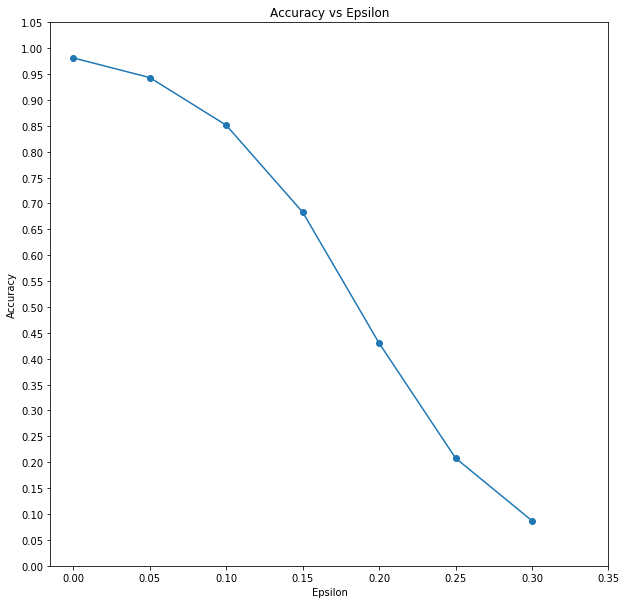

In [23]:
# graphique : precision =fct (perturbation = ϵ)

plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, "o-")
plt.yticks(np.arange(0, 1.1, step=0.05))
plt.xticks(np.arange(0, 0.40, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [18]:
# ================
# Exemples d'exemples contradictoires
# ================
# lorsque epsilon augmente, la précision du test diminue, MAIS les perturbations deviennent
# plus facilement perceptibles. En réalité, il existe un compromis entre la dégradation
# de la précision et la perception qu'un attaquant doit prendre en compte. 
# Ici, nous montrons quelques exemples d’exemples contradictoires réussis à chaque valeur
# epsilon. Chaque ligne du graphique montre une valeur epsilon différente. 
# La première rangée est la ϵ = 0 des exemples qui représentent les images «propres» d’origine,
# sans perturbation. Le titre de chaque image indique 
# la «classification d'origine -> classification contradictoire». 
# Notez que les perturbations commencent à apparaître ϵ = 0.15 et sont assez évidents à ϵ = 0.3.
# Cependant, dans tous les cas, les humains sont toujours capables d'identifier 
# la bonne classe malgré le bruit ajouté.

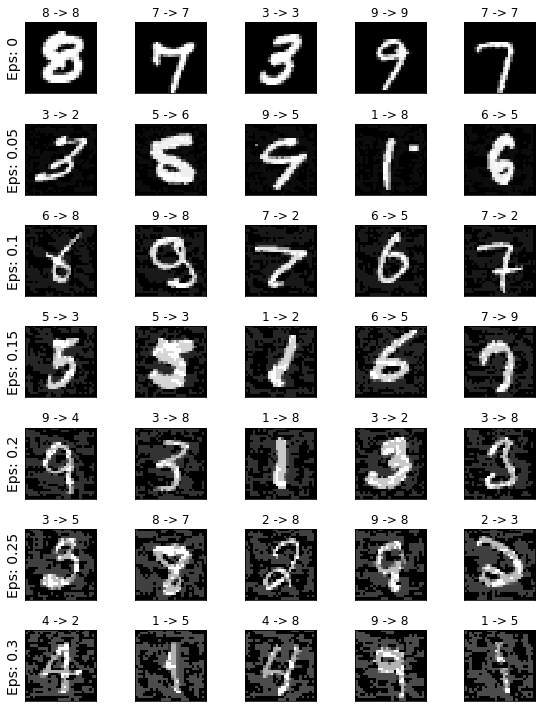

In [19]:
# Donnez plusieurs exemples d’échantillons contradictoires à chaque epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [20]:
# ============
# NEXT = 
# ============
# Les travaux sur la défense mènent également à l’idée de rendre les modèles d’apprentissage
# automatique plus robustes en général, à la fois pour les entrées perturbées de façon naturelle
# et celles construites de manière adverse.

# Adversarial Attacks and Defences Competition
# super interessant = https://arxiv.org/pdf/1804.00097.pdf


In [21]:
# Affichage du temps d execution
print("Temps d execution : %s minutes --- secondes" % round((time.time() - start_time)/60),2)

Temps d execution : 2 minutes --- secondes 2


In [ ]:
# sourcing (lecture adaptation du code): https://pytorch.org/tutorials/beginner/fgsm_tutorial.html